# MIA vs Overfitting

In this notebook we will study the effect of overfitting in MIA's performance, given a CNN model, CIFAR-10 dataset and a MIA framework that will perfrom the attacks for us.

In [1]:
!pip3 install GPUtil

import numpy as np
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers

# for image interpolation
import scipy.ndimage.interpolation as interpolation

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
!cp ../input/mia-v2 ./mia -r
from mia.attack_model import *
from mia.label_only import *
from mia.shadow_models import *
from mia.utilities import *
from mia.wrappers import ConfidenceVectorAttack, LabelOnlyAttack

from tqdm.notebook import tqdm
import sys
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=1df014afa2eeacfc2145713e71525472487d67056a76cf3fc4f92aa7995928b5
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
Num GPUs Available:  1


2022-08-13 11:57:29.272715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 11:57:29.274590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 11:57:29.275630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [10]:
def f_target(X_train, y_train, X_test, y_test, epochs=100):
  """
  Returns a trained target model, if test data are specified we will evaluate the model and print its accuracy
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='tanh'))
  model.add(layers.MaxPooling2D((2, 2)))


  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='tanh'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam(learning_rate=0.001)

  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1e-4, patience=10)
  history = model.fit(X_train, y_train, 
                      epochs=epochs, 
                      validation_data=(X_test, y_test),
                      callbacks=[es]
                      )
  return model, history

In [11]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [12]:
print(f"We have {len(train_images)} train instances and {len(test_images)} test instances.")

We have 50000 train instances and 10000 test instances.


Let us give the attacker 10000 data points and let the rest of them be training-evaluation-testing datapoints for the target model.

In [13]:
attacker_images, attacker_labels = (test_images, test_labels)
N_SHADOWS = 10
D_SHADOW= 1000

In [14]:
def f_shadow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='tanh'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='tanh'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [15]:
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1e-4, patience=10)
attack = ConfidenceVectorAttack(None, (train_images, train_labels), 
                                  (attacker_images, attacker_labels), shadow_creator=f_shadow, attack_model_creator=cifar_10_f_attack_builder,
                                n_shadows=N_SHADOWS, D_shadow_size=D_SHADOW, verbose=True)
attack.perform_attack(shadow={'epochs':100, 'batch_size':128, 'callbacks':[es]})

Epoch 1/100
6/6 [==============================] - 0s 34ms/step - loss: 3.0851 - accuracy: 0.1403 - val_loss: 2.4391 - val_accuracy: 0.2030
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.2030 - val_loss: 2.0737 - val_accuracy: 0.2121
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 1.8718 - accuracy: 0.3582 - val_loss: 1.9897 - val_accuracy: 0.2939
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 1.7724 - accuracy: 0.3731 - val_loss: 1.9928 - val_accuracy: 0.2818
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 1.6582 - accuracy: 0.4179 - val_loss: 1.8323 - val_accuracy: 0.3455
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 1.5006 - accuracy: 0.4791 - val_loss: 1.8341 - val_accuracy: 0.3606
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 1.3894 - accuracy: 0.5224 - val_loss: 1.7663 - val_accuracy: 0.4212
Epoch 8/100
6/6 [========

Epoch 1/100
79/79 [==============================] - 4s 45ms/step - loss: 2.2537 - accuracy: 0.2092 - val_loss: 1.9378 - val_accuracy: 0.2500
Epoch 2/100
79/79 [==============================] - 3s 34ms/step - loss: 1.8834 - accuracy: 0.3004 - val_loss: 1.8815 - val_accuracy: 0.3076
Epoch 3/100
79/79 [==============================] - 3s 37ms/step - loss: 1.7380 - accuracy: 0.3704 - val_loss: 1.7433 - val_accuracy: 0.3671
Epoch 4/100
79/79 [==============================] - 3s 37ms/step - loss: 1.6130 - accuracy: 0.4180 - val_loss: 1.6627 - val_accuracy: 0.4098
Epoch 5/100
79/79 [==============================] - 3s 36ms/step - loss: 1.4805 - accuracy: 0.4768 - val_loss: 1.7038 - val_accuracy: 0.4178
Epoch 6/100
79/79 [==============================] - 3s 34ms/step - loss: 1.4282 - accuracy: 0.4972 - val_loss: 1.6019 - val_accuracy: 0.4279
Epoch 7/100
79/79 [==============================] - 3s 38ms/step - loss: 1.2672 - accuracy: 0.5668 - val_loss: 1.5582 - val_accuracy: 0.4427
Epoch 

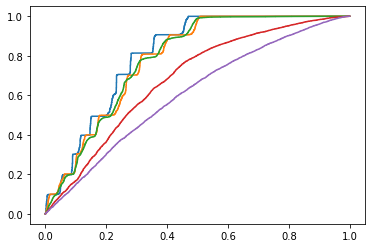

In [16]:
scores = []
history = []
model_vuln = []

for dataset_size in [2500, 5000, 7500, 10000, 20000]:
  X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, train_size=dataset_size, shuffle=True, random_state=0)
  target_model, h = f_target(X_train, y_train, X_test, y_test, epochs=100)
  history.append(h)

  attack.target_model = target_model
  attack.target_dataset = X_train, y_train
  _score = attack.evaluate_attack()
  scores.append(_score)

  model_vuln.append(evaluate_model_vulnerability(target_model, (X_train, y_train), (attacker_images, attacker_labels), 'tf', batch_size=128))


In [19]:
dt_size = [2500, 5000, 7500, 10000, 20000]

Text(0, 0.5, 'Model Vulnerability')

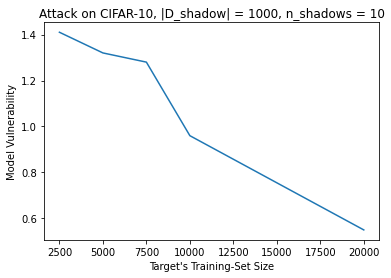

In [20]:
plt.plot(dt_size, model_vuln)
plt.title(f'Attack on CIFAR-10, |D_shadow| = {D_SHADOW}, n_shadows = {N_SHADOWS}')
plt.xlabel('Target\'s Training-Set Size')
plt.ylabel('Model Vulnerability')

Text(0, 0.5, 'AUC Score')

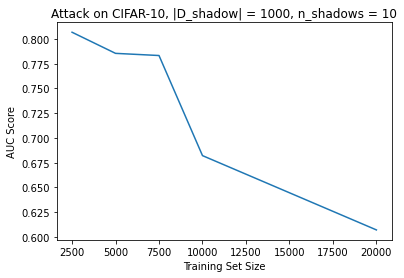

In [21]:
auc_scores = [items[1] for items in scores]

plt.plot(dt_size, auc_scores)
plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('AUC Score')

Text(0, 0.5, 'Recall Score')

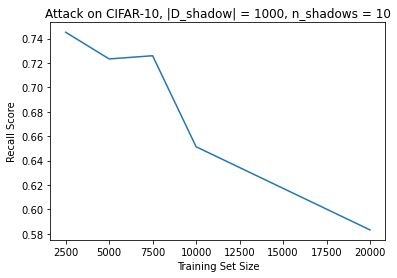

In [22]:
recall_scores = [items[0]['macro avg']['recall'] for items in scores]

plt.plot(dt_size, recall_scores)
plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('Recall Score')

Text(0, 0.5, 'Precision Score')

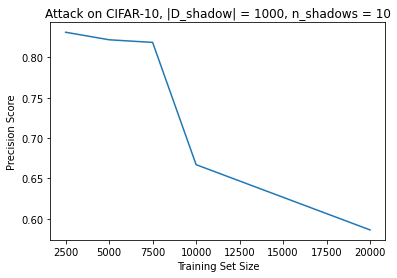

In [23]:
precision_scores = [items[0]['macro avg']['precision'] for items in scores]

plt.plot(dt_size, precision_scores)

plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('Precision Score')

Text(0, 0.5, 'Accuracy Score')

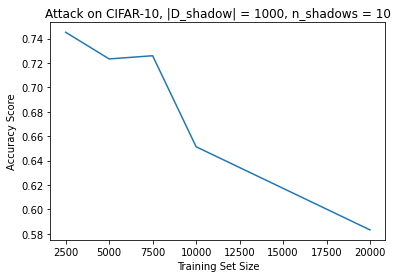

In [24]:
accuracy_scores = [items[0]['accuracy'] for items in scores]

plt.plot(dt_size, accuracy_scores)

plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')